# PMFG -- Centrality Measures Analysis
#### M Chu
Adapted from `playground.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from PMFG_mod import PMFG

from time import time
import timeit

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Importing data
Data downloaded from WRDS and preprocessed.

# NOTE
for large rolling window, we can replicate the centrality feature-clustering phenomenon described in Pozzi. But for smaller rolling window (say half a year), things get messier, and the clustering is much less apparent.

In [2]:
use_IVV = False

if use_IVV:
    raw_asset_prices_df = pd.read_csv("IVV_historical.csv", index_col='Date')

    log_returns_df = np.log(raw_asset_prices_df).diff().dropna()
    # drop first row of raw prices so it has the same dimensions as the log-returns DF
    raw_asset_prices_df = raw_asset_prices_df.iloc[1:]
    stock_names = log_returns_df.columns

    df_shape = (raw_asset_prices_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {raw_asset_prices_df.index[0]} to {raw_asset_prices_df.index[-1]}")

    print(log_returns_df.head())
else:
    log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
    stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
    df_shape = (log_returns_df.shape)
    print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
    print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")
    
ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


## Construction of correlation matrix

In [4]:
#tshift = 252
#raw_corr = log_returns_df.iloc[tshift:126+tshift].corr()
raw_corr = log_returns_df.corr()

shr_coef = 1e-4
#shr_target=np.ones((df_shape[1], df_shape[1]))
shr_target=np.eye(df_shape[1])

correlation_matrix = raw_corr*(1-shr_coef) + shr_target*shr_coef
print('Condition number of sample correlation matrix: %.2e' %np.linalg.cond(raw_corr))
print('Condition number of shrunk correlation matrix: %.2e' %np.linalg.cond(correlation_matrix))
correlation_matrix.head()

Condition number of sample correlation matrix: 4.51e+04
Condition number of shrunk correlation matrix: 4.36e+04


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.382898,0.174961,0.423588,0.371440,0.268825,0.370766,0.574714,0.524620,0.524594,...,0.082312,0.390005,0.344952,0.305398,0.495933,0.383953,0.426343,0.385791,0.402954,0.508536
AAL,0.382898,1.000000,0.202168,0.349767,0.212754,0.242920,0.208959,0.356430,0.336261,0.357479,...,-0.061541,0.401709,0.242301,0.195624,0.393245,0.300815,0.274667,0.333879,0.422293,0.330460
AAP,0.174961,0.202168,1.000000,0.155419,0.147060,0.162803,0.134836,0.215587,0.215358,0.151175,...,0.068318,0.154732,0.180567,0.123950,0.209004,0.176603,0.188930,0.172971,0.265356,0.191637
AAPL,0.423588,0.349767,0.155419,1.000000,0.271367,0.206464,0.363831,0.425138,0.461773,0.513189,...,0.031991,0.442036,0.343888,0.223976,0.365499,0.315368,0.321466,0.350361,0.302726,0.384876
ABBV,0.371440,0.212754,0.147060,0.271367,1.000000,0.304759,0.258362,0.431498,0.328579,0.328576,...,0.059929,0.241190,0.292893,0.261174,0.302585,0.199634,0.334430,0.222451,0.278699,0.380533


D:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


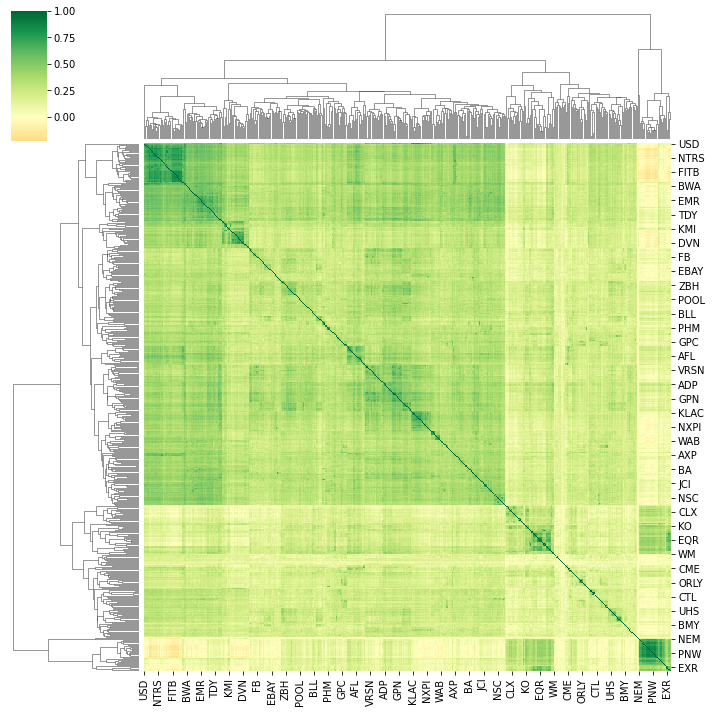

In [5]:
sns.clustermap(correlation_matrix, cmap="RdYlGn", center =0.)
plt.show();

## Graph construction and centrality/peripherality measures
Interestingly, from Pozzi et al., they used different edge weights for each centrality/peripherality meaures.

Pipeline:

1. Construct correlation matrix (for each tick, say, daily data)
    * Robust est. and shrinkage sorely needed
2. Use (off-diagonal) corr. as adjacency matrix;  construct MST/PMFG.etc
3. transform edge weights
    * $R_{ij} \mapsto 1+R_{ij}$ for Deg and Eig-Centrality
    * $R_{ij} \mapsto \sqrt{2(1-R_{ij})}$ for BC, Closeness, and Eccentricity
    * Can also make the graph unweighted; Pozzi reported similar results for weighted/unweighted graphs
4. report centrality/peripherality measures for each node
    * Betweeness-centrality, eccentricity .etc
5. Aggregate the measures; analyze and compose hybrid cen/per index



Centrality/peripherality measures: 
* degree 
* betweenness-centrality
* eccentricity
* closeness
* eigenvector-centrality

In [6]:
G0 = nx.from_pandas_adjacency(correlation_matrix-np.diag(np.diag(correlation_matrix)))
print(nx.info(G0))
print('Sanity check: edge weights are non-binary...')
nx.adjacency_matrix(G0)[0,1]
#nx.draw(G0, with_labels=True, node_size=700, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(Gt1))

Name: 
Type: Graph
Number of nodes: 485
Number of edges: 117370
Average degree: 484.0000
Sanity check: edge weights are non-binary...


0.3828978956166804

In [7]:
timestamp = time()
G0_filtered = PMFG(G0).compute(tol_ratio=.03)
print('Time taken to construct PMFG graph: %.2f s\n' %(time()-timestamp))
print(nx.info(G0_filtered))

# check that the MST is weighted:
#G0_filtered.edges('AAPL')
G0_filtered.adj['AAPL']

Time taken to construct PMFG graph: 55.51 s

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1406
Average degree:   5.9076


AtlasView({'USD': {'weight': 0.6309549601250133}, 'SWKS': {'weight': 0.604107929796799}, 'QRVO': {'weight': 0.5367252469071289}})

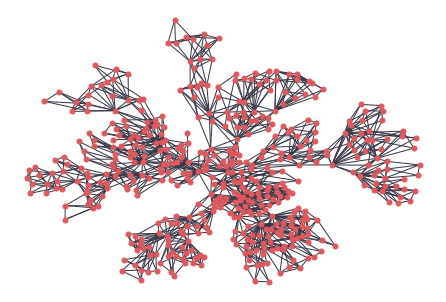

In [9]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.kamada_kawai_layout(G0_filtered))

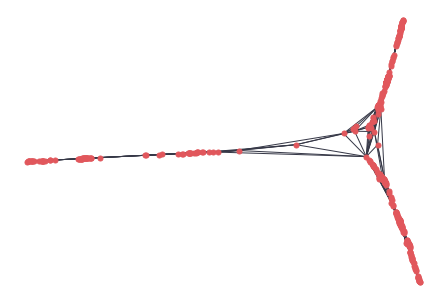

In [11]:
nx.draw(G0_filtered, with_labels=False, node_size=25, node_color="#e1575c", edge_color='#363847',  pos=nx.spectral_layout(G0_filtered))

In [157]:
use_weighted = False

if use_weighted:
    G1 = nx.Graph()
    weight_map = lambda w: 1+w
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
    EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight='weight', max_iter=1000), orient='index', columns = ['EC'])
    PG = pd.DataFrame.from_dict(nx.pagerank(G1, weight='weight'), orient='index', columns = ['PG'])
    
    G1 = nx.Graph()
    weight_map = lambda w: np.sqrt(2*(1-w))
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1, distance='weight'), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1, weight='weight'), orient='index', columns = ['BC'])
else:
    deg= pd.DataFrame.from_dict(dict(G1.degree(weight=None)), orient='index', columns = ['D'])
    EC = pd.DataFrame.from_dict(nx.eigenvector_centrality(G1, weight=None, max_iter=1000), orient='index', columns = ['EC'])
    PG = pd.DataFrame.from_dict(nx.pagerank(G1, weight=None), orient='index', columns = ['PG'])
    ecc= pd.DataFrame.from_dict(nx.eccentricity(G1), orient='index', columns = ['E'])
    clo= pd.DataFrame.from_dict(nx.closeness_centrality(G1, distance=None), orient='index', columns = ['C'])
    BC = pd.DataFrame.from_dict(nx.betweenness_centrality(G1, weight=None), orient='index', columns = ['BC'])

In [158]:
#centralities_names = ['BC', 'C', 'D', 'E', 'EC']
#centralities_names = ['D', 'BC', 'E', 'C', 'EC']
centralities_names = ['D', 'BC', 'nE', 'C', 'EC', 'PG']

centralities = deg.copy()
centralities['BC'] = BC
centralities['nE']  = -ecc
centralities['C']  = clo
centralities['EC'] = EC
centralities['PG'] = PG

print(centralities.head())

        D        BC  nE         C        EC        PG
GOOG    6  0.001575  -9  0.187970  0.047824  0.002157
GOOGL   8  0.001890  -9  0.188867  0.061808  0.002754
MSFT   27  0.074228  -8  0.227709  0.216340  0.008618
AMZN    6  0.001237  -9  0.185983  0.035941  0.002212
V      29  0.033748  -9  0.200846  0.171084  0.009401


## Pearson Correlation Heatmap of Centrality Measures

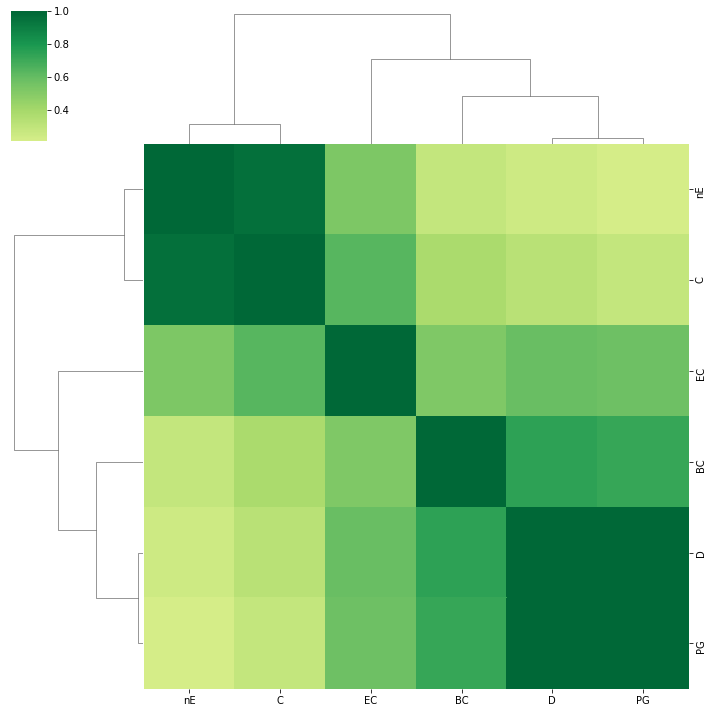

In [159]:
sns.clustermap(centralities.corr(), cmap="RdYlGn", center=0.)
plt.show()

## Spearman correlation heatmap

In [160]:
from scipy.stats import spearmanr

#spearmanr(centralities).correlation
#cen_spcorr,_ = spearmanr(centralities)
cen_spcorr = pd.DataFrame(spearmanr(centralities).correlation, index=centralities_names, columns=centralities_names)
cen_spcorr

,D,BC,nE,C,EC,PG
D,1.000000,0.945954,0.171674,0.208355,0.194286,0.977427
BC,0.945954,1.000000,0.178732,0.221216,0.169084,0.922380
nE,0.171674,0.178732,1.000000,0.971422,0.820602,0.055354
C,0.208355,0.221216,0.971422,1.000000,0.878177,0.084503
EC,0.194286,0.169084,0.820602,0.878177,1.000000,0.091130
PG,0.977427,0.922380,0.055354,0.084503,0.091130,1.000000


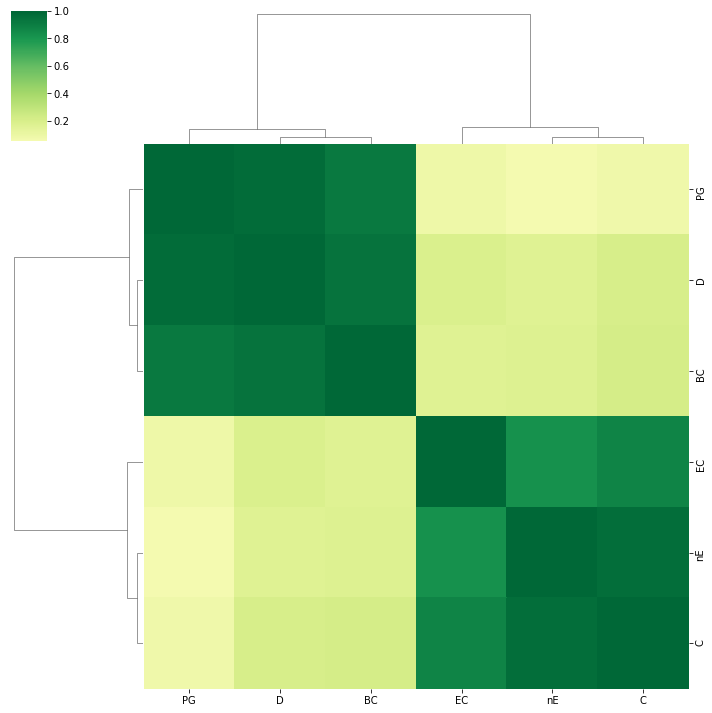

In [161]:
sns.clustermap(cen_spcorr, cmap="RdYlGn", center=0.)
plt.show()

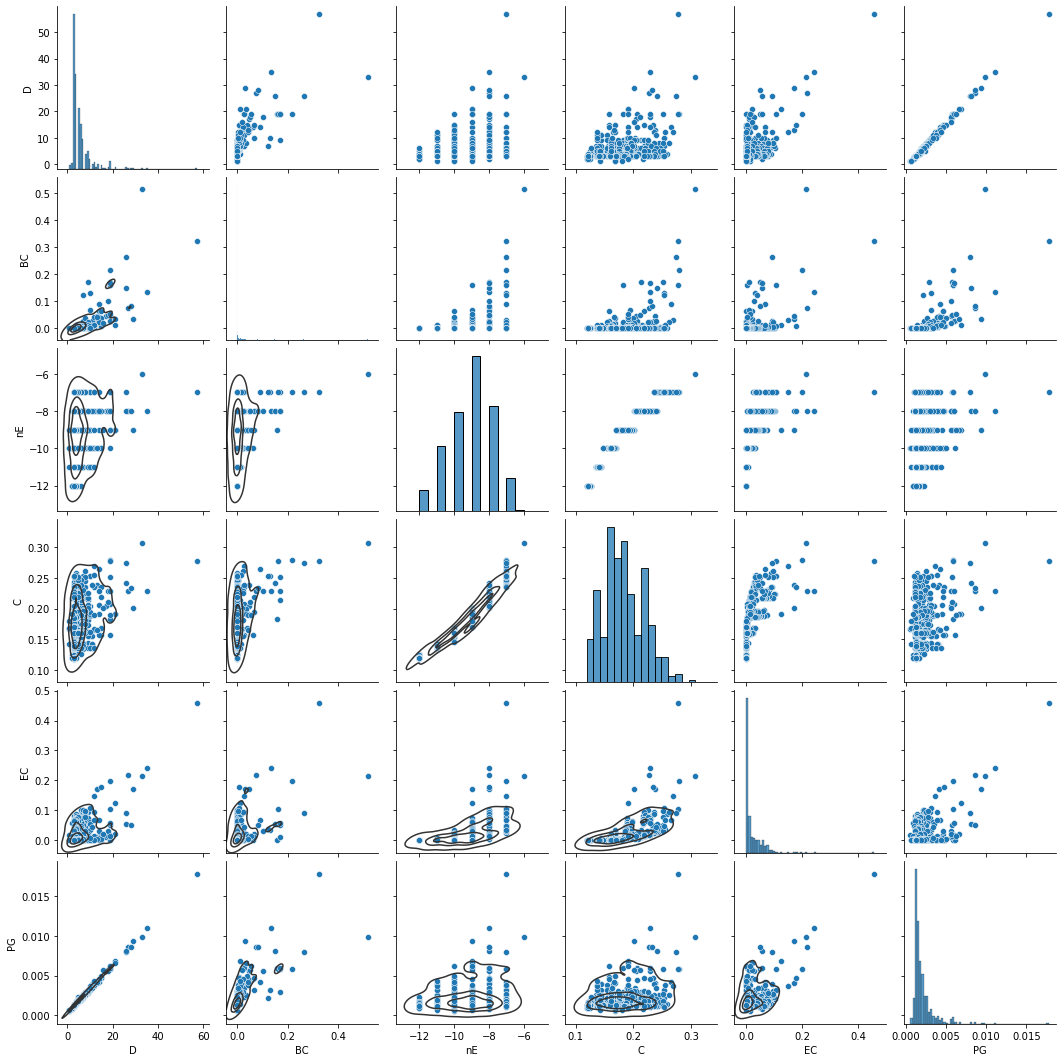

In [162]:
corr_plot = sns.pairplot(data=centralities);

corr_plot.map_lower(sns.kdeplot, levels=4, color=".2");

# Centrality Ranking
As observed in the correlation heatmaps above, the centrality measures has two separate clusters, with very high in-cluster correlation. As per Pozzi et al, we first compute the X/Y indices by averaging the ranking of centrality measures for each cluster; then use X+Y as our aggregated centrality index.

In [163]:

def XY_ranking(G):
    G1 = nx.Graph()
    weight_map = lambda w: 1+w
    for u,v,d in G.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    #deg= pd.DataFrame.from_dict(dict(G1.degree(weight='weight')), orient='index', columns = ['D'])
    #deg_ranking = deg['D'].argsort().argsort()
    PG_ranking = pd.Series(nx.pagerank(G1, weight='weight')).rank()  # almost identical to degree
    EC_ranking = pd.Series(nx.eigenvector_centrality(G1, weight='weight', max_iter=1000)).rank()
    
    G1 = nx.Graph()
    weight_map = lambda w: np.sqrt(2*(1-w))
    for u,v,d in G0_filtered.edges(data=True):
        G1.add_edge(u,v,weight=weight_map(d['weight']))
    NE_ranking = (-pd.Series(nx.eccentricity(G1))).rank()
    CLO_ranking = pd.Series(nx.closeness_centrality(G1, distance='weight')).rank()
    BC_ranking = pd.Series(nx.betweenness_centrality(G1, weight='weight')).rank()
    
    X = (PG_ranking + BC_ranking).rank()
    Y = (NE_ranking + CLO_ranking + EC_ranking).rank()
    return X,Y,(X+Y).rank()


In [164]:
tx,ty,txy = XY_ranking(G0_filtered)

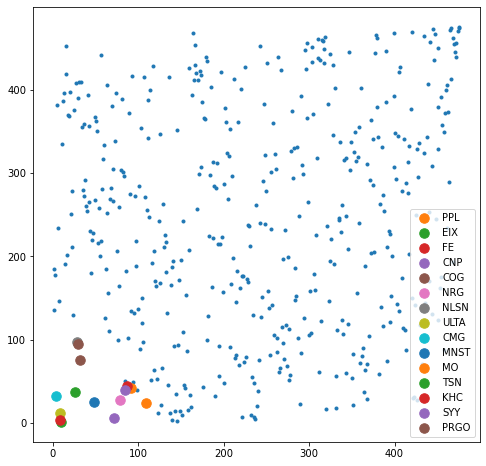

In [172]:
plt.figure(figsize=(8,8))
plt.scatter(tx,ty, marker='.')
#for tick in txy.index[txy> len(txy)-15]:
for tick in txy.index[txy<=15]:
    plt.scatter(tx[tick],ty[tick], s=90, label=tick)
plt.legend();

# WARNING
An incomplete PMFG means that MST is not guaranteed to be included in the PMFG graph. i.e. graph connectedness is not guaranteed; could be missing nodes!



In [166]:
# wrap the whole correlation construction into one function?
def shrinkage_estimator(corr, shrinkage_coef):
    shrinkage_target=np.eye(corr.shape[1])
    return corr*(1-shrinkage_coef) + shrinkage_target*shrinkage_coef

class Backtester:
    def __init__(self, basket_size, basket_update_frequency, rebalance_frequency, rolling_window):
        self.basket_size=  basket_size
        assert basket_update_frequency >= rebalance_frequency
        self.basket_update_frequency = basket_update_frequency
        self.rebalance_frequency     = rebalance_frequency
        self.rolling_window          = rolling_window
    
    def backtest_equal_weight(self, data, verbose = False):
        T, n = data.shape
        portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
        df_portfolios   = pd.DataFrame(columns=portfolio_names)
        # equal-weight buy-and-hold portfolio needs no balancing.
        #eq_weights      = np.array([1/self.basket_size] * self.basket_size)
        
        for t in range(self.rolling_window, T-1):
            #print(t, (t - self.rolling_window)%self.basket_update_frequency)
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                timestamp = time()
                corr   = shrinkage_estimator(data.iloc[t - self.rolling_window:t].corr(), 1e-4)
                G      = nx.from_pandas_adjacency(corr - np.diag(np.diag(corr)))
                G      = PMFG(G).compute(tol_ratio=.03)   # do not save dense corr-network
                #G      = PMFG(G).compute()
                X,Y,XY = XY_ranking(G)
                timestamp = time() - timestamp
                
                # ties??? (highly unlikely, but possible)
                #low_cen_basket  = XY.index[XY <= self.basket_size]
                #high_cen_basket = XY.index[XY>n-self.basket_size+1] #graph completeness issues 
                #high_cen_basket = XY.index[XY > len(XY) - self.basket_size]
                low_cen_basket  = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
                high_cen_basket = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
                random_basket   = XY.index[np.random.choice(len(XY), self.basket_size, replace=False)]
                
                if verbose:
                    print('\nRecomputing filtered network at ', data.index[t])
                    print('Time taken: %.2f\n' %timestamp)
                    print('Peripheral basket: ', low_cen_basket)
                    print('Central basket: '   , high_cen_basket)
                assert len(low_cen_basket) == len(high_cen_basket) == self.basket_size
                
            # low_cen_returns.append(data[low_cen_basket].iloc[t].sum()/self.basket_size)
            #peripheral_return = data[low_cen_basket].iloc[t]  @ eq_weights
            peripheral_return = data[low_cen_basket].iloc[t].mean()
            central_return    = data[high_cen_basket].iloc[t].mean()
            random_return     = data[random_basket].iloc[t].mean()
            market_return     = data.iloc[t].mean()
            df_portfolios.loc[data.index[t+1]] = [peripheral_return, central_return, random_return, market_return]
        return df_portfolios
    


In [167]:
# basket size 30, quarterly rebalance, 1y rolling window for est.
t_back = Backtester(30, 63, 1, 252)
back_results = t_back.backtest_equal_weight(log_returns_df, verbose=True)


Recomputing filtered network at  2017-01-03 00:00:00
Time taken: 69.04

Peripheral basket:  Index(['KR', 'MNST', 'COG', 'SYY', 'NRG', 'FE', 'TSN', 'CAG', 'WMB', 'WLTW',
       'BH', 'SRE', 'RE', 'HSY', 'CHD', 'PRGO', 'D', 'BBY', 'NEE', 'EIX',
       'EXC', 'ULTA', 'WBA', 'WMT', 'UA', 'LB', 'VZ', 'NEM', 'CHRW', 'XOM'],
      dtype='object')
Central basket:  Index(['CAT', 'AMP', 'EMR', 'LNC', 'MTD', 'SNPS', 'MA', 'PKI', 'BAC', 'PRU',
       'JPM', 'MS', 'IVZ', 'PH', 'TMO', 'ITW', 'ETN', 'IEX', 'TEL', 'C', 'USD',
       'APH', 'BLK', 'PAR', 'TCX', 'CMG', 'CMT', 'ENPH', 'TAP', 'PIR'],
      dtype='object')

Recomputing filtered network at  2017-04-04 00:00:00
Time taken: 63.16

Peripheral basket:  Index(['KR', 'MNST', 'KHC', 'TSN', 'NRG', 'WMT', 'SYY', 'COG', 'PRGO', 'HAS',
       'WBA', 'HSY', 'DVA', 'KMB', 'CMG', 'DPZ', 'WMB', 'ALXN', 'CTL', 'NEE',
       'VZ', 'BMY', 'BBY', 'CHRW', 'TYL', 'CVS', 'MKTX', 'D', 'VLO', 'BH'],
      dtype='object')
Central basket:  Index(['ITT', 'PRU', 'BAC

### Information Ratio
Pozzi defined the IR of portfolio as just the mean over volatility of portfolio returns. Benchmark was not explicitly defined -- the implied benchmark is the "zero" risk-free asset (i.e. do-nothing -- zero return).

In [168]:
(back_results).head()

,Peripheral,Central,Random,Market
2017-01-04,0.003820,0.010821,0.008706,0.007712
2017-01-05,0.007478,0.013760,0.009115,0.011049
2017-01-06,-0.000926,-0.005138,-0.008067,-0.002746
2017-01-09,0.000480,0.003411,0.000867,0.003402
2017-01-10,-0.007916,-0.006689,-0.003680,-0.004421


In [169]:
back_results.mean()/back_results.std()

Peripheral    0.062519
Central       0.068225
Random        0.064239
Market        0.082770
dtype: float64

In [170]:
back_results.mean(), back_results.std()

(Peripheral    0.000431
 Central       0.000747
 Random        0.000530
 Market        0.000657
 dtype: float64,
 Peripheral    0.006896
 Central       0.010954
 Random        0.008247
 Market        0.007936
 dtype: float64)

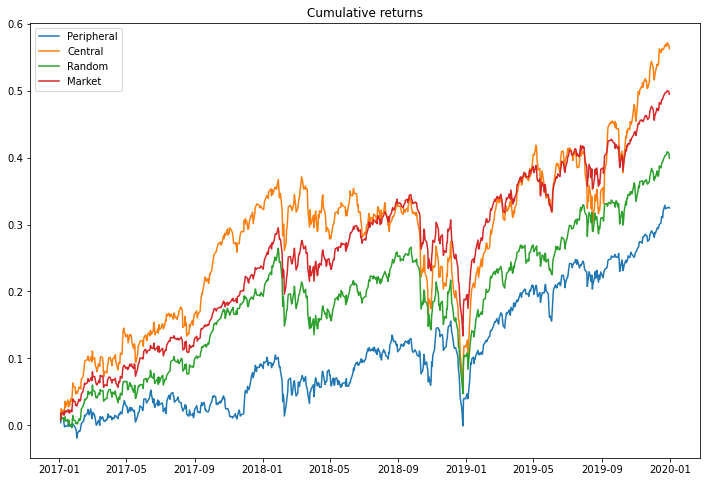

In [171]:
plt.figure(figsize=(12,8))
plt.title('Cumulative returns')
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
#plt.plot(back_results.cumsum(), label=portfolio_names)
for name in portfolio_names:
    plt.plot(back_results[name].cumsum(), label=name)

plt.legend()
plt.show();